* Test if there is a bulge.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools, psu_tools)
import datetime, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

In [3]:
octnowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
maynowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_U.nc')
jannowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_U.nc')

octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc')

In [4]:
octnowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')
maynowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_V.nc')
jannowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_V.nc')

octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc')

In [5]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [6]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted+1,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted+1,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [7]:
def threshold_whole_domain2(grid_T,tst,ted,dep_ind,dep):
    """Plot the boundary of the plume and threshold salinity"""
    
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    ## plot plume edge on 
    S_thre,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(1,))
    print(S_thre)
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])

In [8]:
def area_plume_new(grid_T,tst,ted,dep_ind,dep,S_thre,yslices,xslices):
    """S_thre is an input now"""
    jss  = []; iss = []; 
    SS,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for j in np.arange(yslices):
        for i in np.arange(xslices):
            if W[j,i] - S_thre >= 0.:
                jss.append(j)
                iss.append(i)
    return jss, iss,W

In [9]:
def freshwater_xy(grid_T,tst,ted,dep_ind,xslices):
    """Calculate the freshwater over depths for all grid cells"""
    S0 = 30;
    S = grid_T.variables['vosaline'][tst:ted+1,:,:,:xslices]
    ssh = grid_T.variables['sossheig'][...,:xslices]
    fresh = np.zeros(S.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[...,:xslices]*tmask[...,:xslices],axis = 0)
            fresh[t,z] = (1-S[t,z]/S0)*e3t[z,:,:xslices]*adj_ssh[:]*tmask[z,:,:xslices] ## mask zero salinity here
    fresh_depth = np.nansum(fresh,axis = 1) ## integral over depths
    fresh_ave = np.nanmean(fresh_depth,axis=0) ## averaged over time of fresh water at each grid cell
    return fresh_ave

In [10]:
def plume_position_new(grid_T,tst,ted,dep,fresh_ave,S_thre,yslices,xslices):
    """if only use fixed plume threshold"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    SS,W = determine_plume_method2_onlysalinity(grid_T,tst,ted,dep)
    for jj in np.arange(yslices):
        for ii in np.arange(xslices):
            if W[jj,ii] - S_thre >= 0.:
                j_po_nu[jj,ii] = np.nan
                j_po_de[jj,ii] = np.nan
                i_po_nu[jj,ii] = np.nan
                i_po_de[jj,ii] = np.nan
            elif  W[jj,ii] - S_thre < 0:
                j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

In [11]:
def Add_quiver(grid_U1, grid_U2, grid_V1, grid_V2, t1, t2):
    """
    """
    theta = np.pi*29/180
    U = {};V= {}
    for gridU,gridV,run in zip([grid_U1,grid_U2],[grid_V1,grid_V2],['all','nowind']):
        u = gridU.variables['vozocrtx'][t1:t2+1,0]
        v = gridV.variables['vomecrty'][t1:t2+1,0]
        U[run],V[run] = viz_tools.unstagger(u,v)
        #rotate       
        U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
        V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
        U[run] = np.nanmean(U[run],axis = 0)
        V[run] = np.nanmean(V[run],axis = 0)
    return U,V

In [12]:
def plot_plume_position(grid_T1,grid_T2,grid_U1,grid_U2, grid_V1, grid_V2,
                        tst,ted,dep_ind,dep,S_thre,yslices,xslices,strings,st = 3):
    """Plot the plume position under with and without Coriolis force, or with or without moderate/strong wind,
    here by convention, grid_T1 should always be all_T.nc. Pcolormesh of last plot is the difference."""
    fresh_aves = {}; ipos = {};jpos = {}
    fig,axs = plt.subplots(1,3,figsize = (20,9))
    for gridT, string, ax,c in zip([grid_T1,grid_T2],strings,[axs[0],axs[1]],['g','purple']):
        jss,iss,W = area_plume_new(gridT,tst,ted,dep_ind,dep,S_thre,yslices,xslices) ## just used fixed boundary
        fresh_aves[string] = freshwater_xy(gridT,tst,ted,dep_ind,xslices)
        jpos[string],ipos[string] = plume_position_new(gridT,tst,ted,dep,fresh_aves[string],S_thre,yslices,xslices)
    
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        
        fr_aveno0 = np.ma.masked_values(fresh_aves[string],0)
        CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'jet')
        cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
        cbar.set_label('Freshwater at each grid cell [m]')
        ax.plot(lon[jpos[string],ipos[string]],lat[jpos[string],ipos[string]],color =c,marker = '*',markersize = 14,label =string)
        ax.legend(loc = 'best')
        CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
        plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
        ax.plot(lon[0:,xslices],lat[0:,xslices],'r-')
        ## add quiver
        U,V = Add_quiver(grid_U1, grid_U2, grid_V1, grid_V2, tst, ted)
        quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U[string][::st, ::st], V[string][::st,::st],\
                           pivot='mid',scale=4,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black')
    ax = axs[2]
    fr_aveno0 = np.ma.masked_values(fresh_aves[strings[1]]-fresh_aves[strings[0]],0)
    CS = ax.pcolormesh(lon[:yslices,:xslices],lat[:yslices,:xslices],fr_aveno0[:],vmin = -2, vmax = 2,cmap = 'bwr')
    cbar = fig.colorbar(CS,ax = ax,orientation='horizontal')
    cbar.set_label('Difference of freshwater at each grid cell [m]')
    ax.plot(lon[jpos[strings[0]],ipos[strings[0]]],lat[jpos[strings[0]],ipos[strings[0]]],color = 'g',marker = '*',markersize = 14,label =strings[0])
    ax.plot(lon[jpos[strings[1]],ipos[strings[1]]],lat[jpos[strings[1]],ipos[strings[1]]],color = 'purple',marker = '*',markersize = 14,label =strings[1])
    ax.legend(loc = 'best')
    for ax in axs:    
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.plot(X[430:486, 259],Y[430:486, 259],'b-')
        ax.plot(X[430, 259:300],Y[430, 259:300],'r-')
        ax.plot(X[486, 259:300],Y[486, 259:300],'r-')
        ax.plot(X[430:486, 300],Y[430:486, 300],'b-')
        ax.set_xlim([-124.,-122.6])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
        ax.set_ylim([48.85,49.65])
    return jpos,ipos

In [13]:
def quiver_salinity(grid_T1,grid_T2,grid_U1,grid_U2,grid_V1,grid_V2,t1,t2,colormap,st,dep,cmin = -6,cmax = 6):
    """Quiver velocity on top of surface salinity"""
    fig,axs = plt.subplots(1,3,figsize=(20,6))
    cm = plt.cm.get_cmap(colormap,12)
    theta = np.pi*29/180
    S = {};U = {};V= {}
    for gridT, gridU,gridV,run, ax in zip([grid_T1,grid_T2],[grid_U1,grid_U2],[grid_V1,grid_V2],['all','nowind'],[axs[0],axs[1]]):
        lon = gridT.variables['nav_lon']
        lat = gridT.variables['nav_lat']
        S[run] =np.ma.masked_values(np.nanmean(gridT.variables['vosaline'][t1:t2+1,0],axis = 0),0)
        u = gridU.variables['vozocrtx'][t1:t2+1,0]
        v = gridV.variables['vomecrty'][t1:t2+1,0]
        U[run],V[run] = viz_tools.unstagger(u,v)
        #rotate       
        U[run] = U[run]*np.cos(theta) - V[run]*np.sin(theta)
        V[run] = U[run]*np.sin(theta) +V[run]*np.cos(theta)
        U[run] = np.nanmean(U[run],axis = 0)
        V[run] = np.nanmean(V[run],axis = 0)
            
        mesh=ax.pcolormesh(lon,lat,S[run],vmin =0,vmax = 33,cmap=cm) 
        cbar = fig.colorbar(mesh,ax = ax)
        cbar.set_label('Practical Salinity')
        quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U[run][::st, ::st], V[run][::st,::st],\
                           pivot='mid',scale=4,width=0.005, color='black' )
        ax.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black')
        ax.plot(X[430:486, 259],Y[430:486, 259],'b-')
        ax.plot(X[430, 259:300],Y[430, 259:300],'r-')
        ax.plot(X[486, 259:300],Y[486, 259:300],'r-')
        ax.plot(X[430:486, 300],Y[430:486, 300],'b-')
        
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([-124.,-122.8])
        ax.set_ylim([48.9,49.5])
        ## add minimum salinity plot if available
    sal_diff = S['nowind'] - S['all']
    U_diff = U['nowind'] - U['all']
    V_diff = V['nowind'] - V['all']
    ax = axs[2]
    mesh=ax.pcolormesh(lon,lat,sal_diff,cmap='RdBu_r',vmin=cmin, vmax=cmax)
    cbar = fig.colorbar(mesh,ax = ax)
    cbar.set_label('Difference of Practical Salinity')
    quiver = ax.quiver(lon[1::st,1::st], lat[1::st,1::st],U_diff[ ::st, ::st], V_diff[::st,::st],\
                           pivot='mid',scale=4,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.25, 0.1, '0.1 m/s',coordinates='data', color='black', labelcolor='black')
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])
    return S, U,V

# Plot

/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/ocean/jieliu/Anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


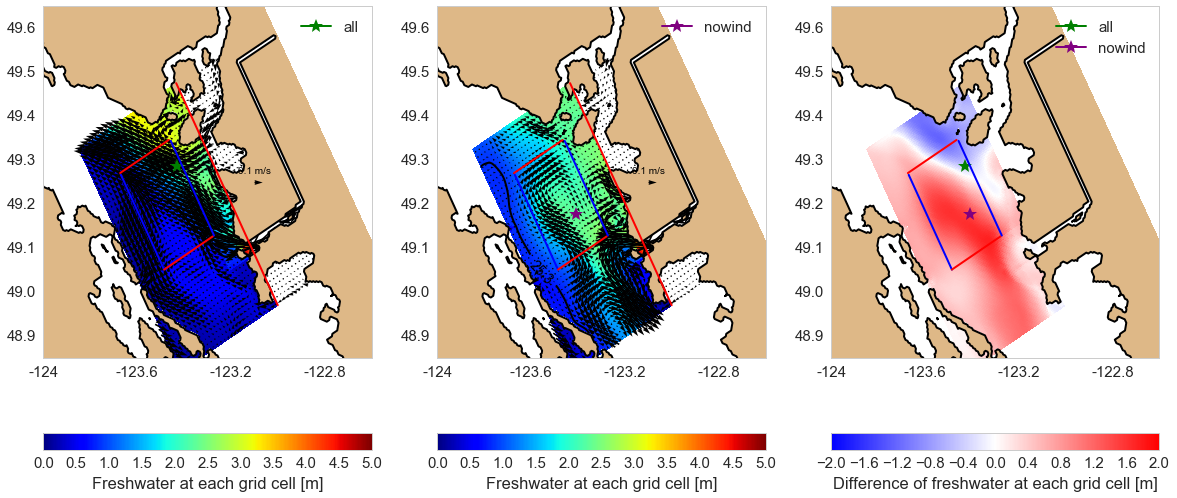

In [16]:
## Oct moderate wind
yslices = tmask.shape[1]
xslices = tmask.shape[2]-77
jpos_oct_windMo,ipos_oct_windMo = plot_plume_position(octall_T,octnowind_T,octall_U, octnowind_U,
                                                      octall_V, octnowind_V,
                                                      408,480,10,0,25.3,yslices,xslices,['all','nowind'])

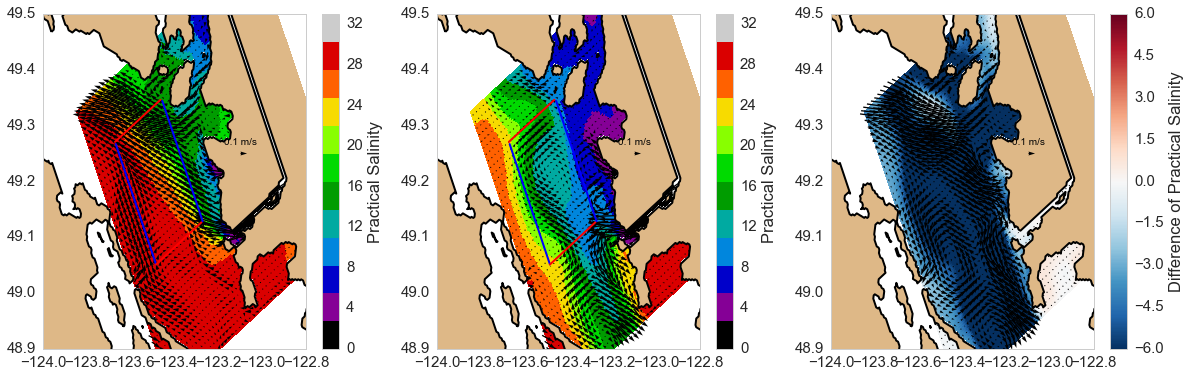

In [81]:
S_oct,U_oct,V_oct = quiver_salinity(octall_T,octnowind_T,octall_U,octnowind_U,octall_V,octnowind_V,408,480,'spectral',3,0)

(48.85, 49.65)

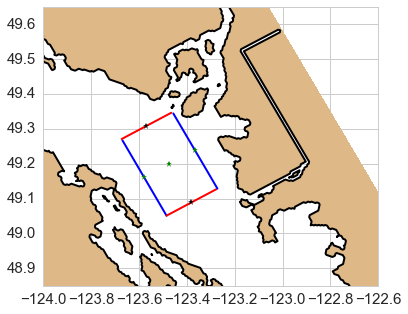

In [14]:
fig,ax = plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.plot(X[430:486, 259],Y[430:486, 259],'b-')
ax.plot(X[430, 259:300],Y[430, 259:300],'r-')
ax.plot(X[486, 259:300],Y[486, 259:300],'r-')
ax.plot(X[430:486, 300],Y[430:486, 300],'b-')
ax.plot(X[458,279],Y[458,279],'g*')
ax.plot(X[458,259],Y[458,259],'g*')
ax.plot(X[458,300],Y[458,300],'g*')
ax.plot(X[430,279],Y[430,279],'k*')
ax.plot(X[486,279],Y[486,279],'k*')
ax.set_xlim([-124.,-122.6])
ax.set_ylim([48.85,49.65])

In [103]:
geo_tools.haversine(X[458,279],Y[458,279],X[458,300],Y[458,300])

9.0524665084732714

In [105]:
geo_tools.haversine(X[458,279],Y[458,279],X[486,279],Y[486,279])

13.96321600058225

In [121]:
print('modeled mean surface current in the bulge is ', 
      np.nanmean(V_oct['nowind'][430-380:486-380,259-240:300-240]), ' m/s')

modeled mean surface current in the bulge is  0.0247428  m/s


* Geostrophic flow:

$\frac{\partial v}{\partial z} = \frac{g}{f \rho_{0}}\frac{\partial \rho}{\partial x}$

$V \approx \frac{g}{f}\frac{\Delta z}{\rho_{0}}\frac{\Delta \rho}{\Delta x} = \frac{10}{1\times 10^{-4}}\frac{10}{1 \times 10^{3}}\frac{4}{8\times 10^{3}} = \frac{4}{8} = 0.5 m/s$

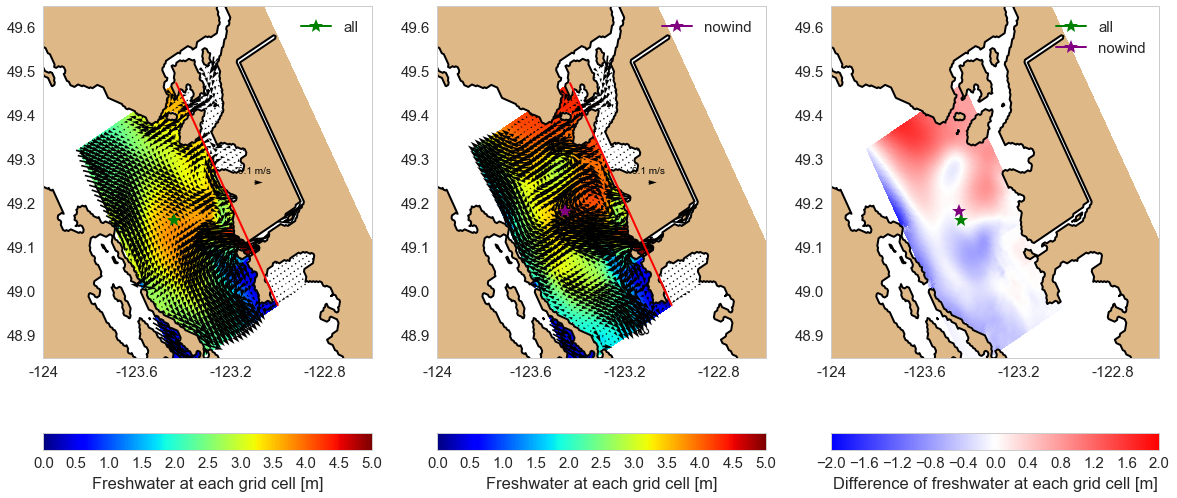

In [19]:
## May moderate wind
jpos_may_windMo,ipos_may_windMo = plot_plume_position(mayall_T,maynowind_T,mayall_U, maynowind_U,
                                                      mayall_V, maynowind_V,
                                                      432,503,10,0,18.3,yslices,xslices,['all','nowind'])

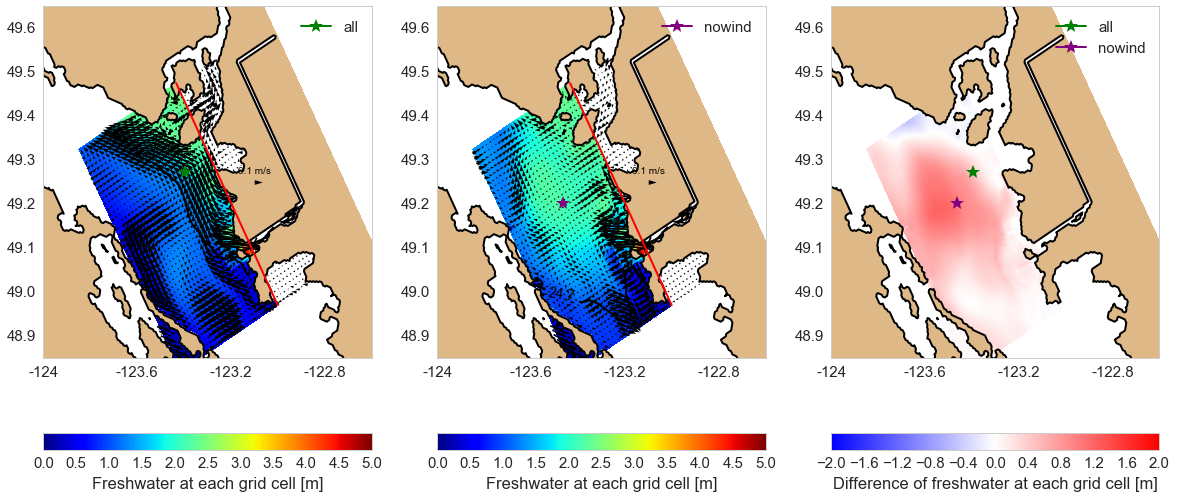

In [20]:
## Jan high wind
jpos_jan_wind,ipos_jan_wind = plot_plume_position(janall_T,jannowind_T,janall_U, jannowind_U,
                                                      janall_V, jannowind_V,
                                                      624,671,10,0,24.7,yslices,xslices,['all','nowind'])

# Take Oct moderate wind as an example:

In [17]:
print(jpos_oct_windMo['all'],ipos_oct_windMo['all'])

92.0676954903 57.5067309573


In [18]:
v = mayall_V.variables['vomecrty']
v_integral = np.cumsum(v[:,0,jpos_oct_windMo['nowind'],ipos_oct_windMo['nowind']] * 3600)

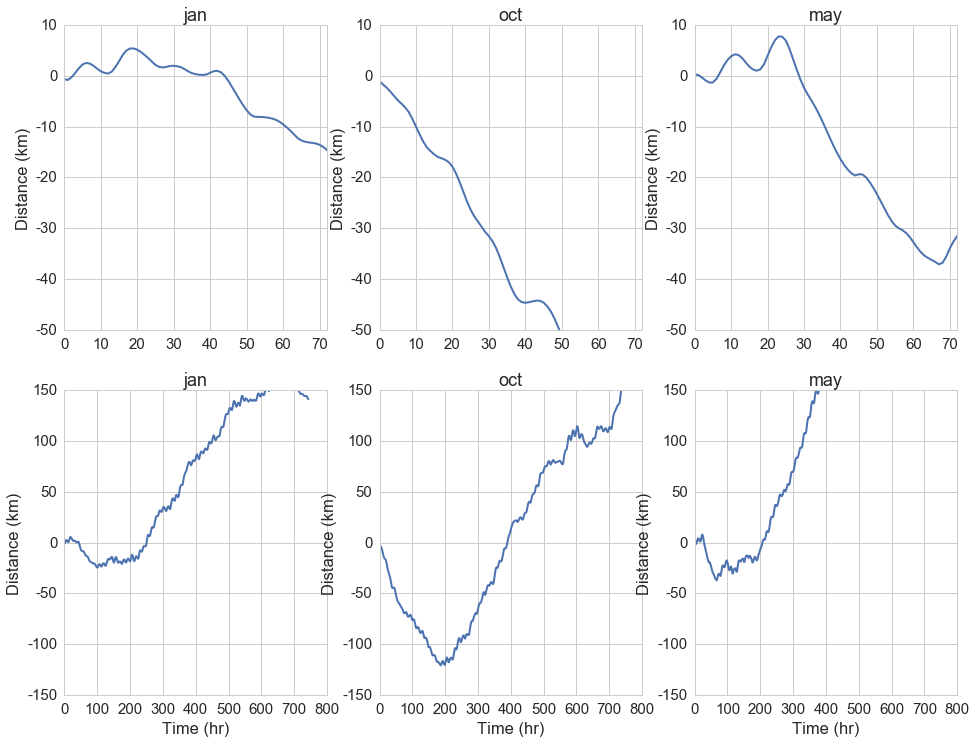

In [23]:
fig, axs = plt.subplots(2,3,figsize = (16,12))
for ax, gridV, title in zip(axs[0,:], [janall_V,octall_V,mayall_V],
                           ['jan','oct','may']):
    v = gridV.variables['vomecrty']
    v_integral = np.cumsum(v[:,0,jpos_oct_windMo['nowind'],ipos_oct_windMo['nowind']] * 3600)
    ax.plot(v_integral)
    ax.set_title(title)
    ax.set_xlim([0,72])
    ax.set_ylim([-50e3,10e3])
    ax.set_yticklabels(np.arange(-50,20,10))
    ax.set_ylabel('Distance (km)')
for ax, gridV, title in zip(axs[1,:], [janall_V,octall_V,mayall_V],
                           ['jan','oct','may']):
    v = gridV.variables['vomecrty']
    v_integral = np.cumsum(v[:,0,jpos_oct_windMo['nowind'],ipos_oct_windMo['nowind']] * 3600)
    ax.plot(v_integral)
    ax.set_title(title)
    ax.set_ylim([-150e3,150e3])
    ax.set_yticklabels(np.arange(-150,200,50))
    ax.set_ylabel('Distance (km)')
    ax.set_xlabel('Time (hr)')    

* Eddy radius ~8 km W-E direction and ~13 km N-S direction.
* Rossby deformation radius ~ 7km from normal mode calculation.
* Tidal excursion ~ 6km.